In [37]:
'''Import packages'''
'''Requires numpy, pandas, scikit-learn, and matplotlib/seaborn'''
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("ticks")

import analysis_functions

from IPython.display import display, HTML

In [38]:
'''Import data'''
data_abs = pd.read_csv('data/Chloroplasts_removed/nochloro_absolute_otu.tsv', sep=' ', index_col=None, header=0)
#data_rel = pd.read_csv('data/Chloroplasts_removed/nochloro_relative_otu.tsv', sep=' ', index_col=None, header=0)
target = pd.read_csv('data/Chloroplasts_removed/nochloro_HNA_LNA.tsv', sep=' ', index_col=0, header=0)
#productivity = pd.read_csv('data/Chloroplasts_removed/productivity_data.tsv', sep=' ', index_col=0, header=0)

In [39]:
'''Set sample names as index and shuffle data'''
data_abs.set_index(target.samples,inplace=True)
#data_rel.set_index(target.samples,inplace=True)
data_abs = data_abs.sample(frac=1, random_state=3)
#data_rel = data_rel.sample(frac=1, random_state=3)
target = target.sample(frac=1, random_state=3)
#productivity = productivity.sample(frac=1, random_state=3)

#Create target columns of HNA-values: 
hna = target.loc[:,'HNA.cells']
hna_rel = hna/target.loc[:,'Total.cells']
hna = pd.Series(hna, index=hna.index)
hna_rel = pd.Series(hna_rel, index=hna_rel.index)

**Preprocessing of data**: we filter out those OTUs which have very low abundances and so give rise to (almost) zero-columns. Therefore an OTU has to have a minimal relative abundance in one sample, defined by the parameter $abun$. From previous analyses showed that we could set $abun = 0.01$ without degrading the performance. 

In [41]:
abun = 0.01

In [70]:
from analysis_functions import preprocess_df
data_abs = preprocess_df(data_abs,abun,True)
otus = list(data_abs.columns)

print('Number of OTUs: ' + str(len(otus)))

Number of OTUs: 263


**Standardize data: **

In [71]:
scaler = StandardScaler()
data_abs = pd.DataFrame(scaler.fit_transform(data_abs.loc[:,otus]), index=data_abs.index, columns=otus)

Let's have a look at the heatmap of mutual **spearman correlations**: 

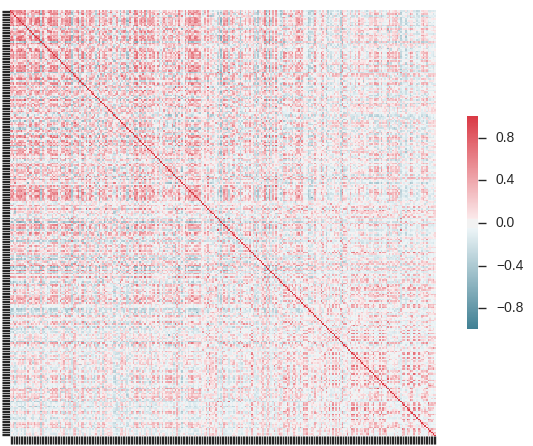

In [43]:
corr = data_abs.corr('spearman')
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = False

f, ax = plt.subplots()
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, square=True, annot=False, xticklabels=False, yticklabels=False, linewidths=.0, cbar_kws={"shrink": .5}, ax=ax,  annot_kws={"size": 16})     
ax.tick_params(labelsize=0)
plt.show()

Let's compare statistical models using a **4x5 cross-validation** scheme: 
- Lasso
- Ridge regression
- Random Forest regression

In [44]:
from analysis_functions import perform_nested_lasso_cv, perform_nested_ridge_cv, perform_nested_RF_cv
from analysis_functions import get_r2

alphas_L, preds_L = perform_nested_lasso_cv(data_abs.loc[:,otus],hna)
alphas_RR, preds_RR = perform_nested_ridge_cv(data_abs.loc[:,otus],hna)
preds_RF = perform_nested_RF_cv(data_abs.loc[:,otus],hna)

r2_L = get_r2(hna,preds_L)
r2_RR = get_r2(hna,preds_RR)
r2_RF = get_r2(hna,preds_RF)

print('R2 Lasso: ' + str(r2_L))
print('R2 Ridge regression: ' + str(r2_RR))
print('R2 Random Forest regression: ' + str(r2_RF))

R2 Lasso: 0.802561725836
R2 Ridge regression: 0.916420848665
R2 Random Forest regression: 0.724905858004


Although Ridge regression seems the best model so far, the Lasso gives satisfying results. Let's use the _randomized_ Lasso to select the most important OTU's: 

In [49]:
from analysis_functions import perform_randomizedLasso

otu_scores = perform_randomizedLasso(data_abs.loc[:,otus], hna, alphas_L.mean())
otu_scores = pd.Series(otu_scores, index=otus)
otu_scores.sort_values(ascending=False,inplace=True)

#Display top-20 OTUs:
display(otu_scores.head(20))

Otu000005    0.952
Otu000128    0.948
Otu000067    0.904
Otu000098    0.892
Otu000224    0.868
Otu000050    0.860
Otu000084    0.850
Otu000009    0.840
Otu000123    0.838
Otu000173    0.792
Otu000124    0.734
Otu000914    0.728
Otu000203    0.714
Otu000572    0.710
Otu000011    0.704
Otu000025    0.704
Otu000063    0.682
Otu000960    0.668
Otu000016    0.666
Otu000047    0.664
dtype: float64

Each OTU is now associated with a certain score. The higher this score, the more it is selected when fitting a Lasso to a bootstrap subsample. We can now fit a threshold in order to determine the score which gives rise to the highest $R^2$, and thus, the optimal subset of OTU's. 

In [58]:
thresholds = np.arange(0,1,0.02)
r2_scores = np.zeros(len(thresholds))
dummy=0

#Make copy of otu_scores to be able to rerun analysis: 
scores = otu_scores
for thresh in thresholds: 
    scores = otu_scores[otu_scores.values > thresh]
    features_new = scores.index
    if(len(features_new) > 0): 
        #alphas, preds = perform_nested_ridge_cv(data_abs[features_new],hna)
        alphas, preds = perform_nested_lasso_cv(data_abs[features_new],hna)
        r2_scores[dummy] = get_r2(hna,preds)
    dummy+=1

/home/prubbens/anaconda3/lib/python3.4/site-packages/matplotlib/__init__.py:898: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


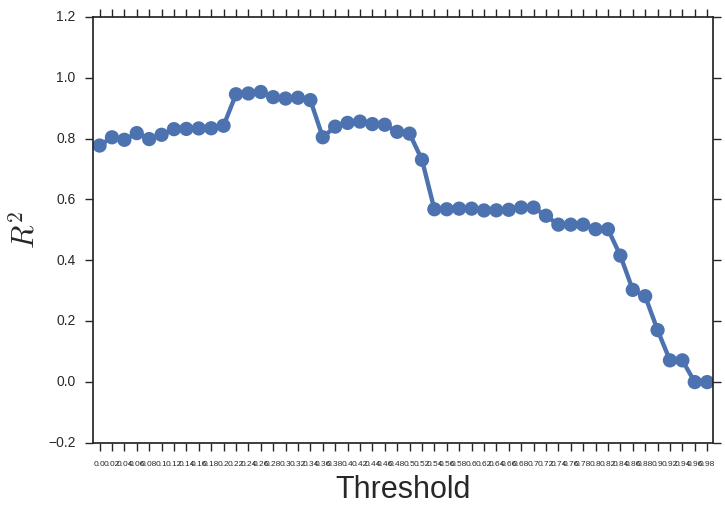

In [59]:
plt.figure()
sns.pointplot(thresholds,r2_scores, scatter_kws={"s": 0.7})
plt.xlabel('Threshold', size=22)
plt.xticks(size=6)
plt.ylabel(r'$R^2$', size=22)
plt.yticks(size=10)
plt.show()

Choose the value for which $R^2$ is maximal: 

In [60]:
r2_max = r2_scores.max()
r2_max_idx = r2_scores.argmax()
thresh_max = thresholds[r2_max_idx]
print('R2 max = ' + str(r2_max))
print('Optimal threshold = ' + str(thresh_max))

R2 max = 0.952886419513
Optimal threshold = 0.26


Let's select the optimal list of OTU's and evaluate it's use when fitting a Lasso model to it: 

In [62]:
optimal_scores = otu_scores[otu_scores.values>thresh_max]
selected_otus = optimal_scores.index
print('Number of selected OTUs: ' + str(len(selected_otus)))

alphas_opt, preds_opt = perform_nested_lasso_cv(data_abs[selected_otus], hna)
r2_final = get_r2(hna, preds_opt)
print('r2: ' + str(r2_final))

from analysis_functions import get_r2_adj
r2_adj = get_r2_adj(r2_final, data_abs.shape[0], len(selected_otus))
print('r2_adj: ' + str(r2_adj))

Number of selected OTUs: 99
r2: 0.952886419513
r2_adj: 0.888992659674


This means that our optimal list contains **99 OTU's**. This results in an $R^2_{adj} = 0.889$. Additionally we can look at the pearson correlation between the selected OTU's and the HNA count: 

In [67]:
from scipy.stats import pearsonr, spearmanr
r_pearson = np.zeros(len(selected_otus))
r_spearman = np.zeros(len(selected_otus))
p_pearson = np.zeros(len(selected_otus))
p_spearman = np.zeros(len(selected_otus))

t=0
for otu in selected_otus: 
    r_pearson[t], p_pearson[t] = pearsonr(hna,data_abs.loc[:,otu])
    r_spearman[t], p_spearman[t] = spearmanr(hna,data_abs.loc[:,otu])
    t+=1

df = pd.DataFrame(optimal_scores)
df['r_pearson'] = r_pearson
df['p_pearson'] = p_pearson
df['r_spearman'] = r_spearman
df['p_spearman'] = p_spearman

display(df.head(20))

,0,r_pearson,p_pearson,r_spearman,p_spearman
Otu000005,0.952,0.331986,8.114232e-06,0.403321,3.756876e-08
Otu000128,0.948,0.176373,2.027444e-02,0.018396,8.101558e-01
Otu000067,0.904,0.289931,1.091722e-04,0.108329,1.559888e-01
Otu000098,0.892,0.446080,7.708688e-10,0.467909,8.525018e-11
Otu000224,0.868,0.248549,9.760025e-04,0.402360,4.074873e-08
Otu000050,0.860,0.304793,4.555944e-05,0.514427,4.495292e-13
Otu000084,0.850,0.365912,7.394512e-07,0.505300,1.340360e-12
Otu000009,0.840,0.566218,4.712164e-16,0.695809,2.293279e-26
Otu000123,0.838,0.388399,1.289391e-07,0.339322,4.948273e-06
Otu000173,0.792,0.528684,7.633332e-14,0.704952,2.638198e-27


What is the relation between the HNA counts and the total cell counts? 

In [68]:
from scipy.stats import linregress

output = linregress(hna,target.loc[:,'Total.cells'])
r2_totcells = output[2]**2
r2_totcells_adj = get_r2_adj(r2_totcells,target.shape[0],1)

print('R2 total cells and HNA counts: ' + str(r2_totcells))
print('Adjusted R2 total cells and HNA counts: ' + str(r2_totcells_adj))


R2 total cells and HNA counts: 0.719491782031
Adjusted R2 total cells and HNA counts: 0.717851383095


**Main conclusions: **
- From the possible list of OTU's we are able to determine quite well which OTU's are related to HNA counts (bridging the gap between FCM and sequencing).  
- We have been able to reduce the list of possible OTU's significantly. 
- We are left with **99 OTU's** which results in an $R^2_{adj} = 0.889$. 
- This means that there is added value in inspecting the abundances of OTU's, instead of relating the total cell counts to the HNA counts ($R^2_{adj} = 0.718$). 
- The **randomized Lasso** seems an effective approach in doing so. 
- We can start looking for selection criteria based on both mutual correlations and scores coming out of the randomized Lasso. 